In [44]:
# imports
from tqdm import tqdm
import random
import os
import time
# Turn off tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# For Data Processing & ML Models
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import cv2

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Enable offline usage of plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from IPython.display import clear_output
clear_output()


**For uniform results, random seed is required**

In [45]:
tf.random.set_seed(100)
np.random.seed(100)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [46]:
!pip install split-folders

# 1. EDA

In [47]:
path = "/kaggle/input/covid-tb-pneumonia/covid_tb_pneumonia_ds/"

In [48]:
def load_data(dir):
    return os.listdir(dir)

In [49]:
load_data(path)

['Pneumonia', 'Tuberculosis', 'Normal', 'Covid-19']

## Splitting the data into train, test and validation : 80%, 10% and 10%

It is generally recommended to split the data into train, test, and validation sets before preprocessing the data. This is because preprocessing techniques such as normalization, scaling, and feature selection are often based on the statistics of the training set, and applying these techniques before splitting the data can lead to data leakage and overfitting

In [50]:
#split the dataset into train, test and validation
import splitfolders
input_path = path
splitfolders.ratio(input_path, 'dataset', ratio = (0.80,0.1,0.1), seed = 42)

Copying files: 18781 files [01:06, 281.70 files/s] 


## Distibution of data

In [51]:
train_dir = '/kaggle/working/dataset/train/'
os.listdir(train_dir)

['Normal', 'Tuberculosis', 'Pneumonia', 'Covid-19']

In [52]:
# Define the directory paths
train_dir = '/kaggle/working/dataset/train'
test_dir = '/kaggle/working/dataset/test'
val_dir = '/kaggle/working/dataset/val'
# Put them to a dataframe
data_directories = [train_dir, test_dir, val_dir]
all_paths = []
all_labels = []
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        all_paths.append(image_path)
        all_labels.append(label)
all_paths, all_labels = shuffle(all_paths, all_labels)
pd.set_option('display.max_colwidth', None)
df_train = pd.DataFrame({'path':all_paths, 'label':all_labels})
df_train.head()

,path,label
0,/kaggle/working/dataset/train/Normal/Normal-1567.png,Normal
1,/kaggle/working/dataset/train/Covid-19/COVID-1791.png,Covid-19
2,/kaggle/working/dataset/train/Covid-19/COVID-1531.png,Covid-19
3,/kaggle/working/dataset/train/Normal/Normal-1222.png,Normal
4,/kaggle/working/dataset/train/Normal/Normal-7320.png,Normal


In [53]:
print("shape of data:",df_train.shape)
print("------------------------------------")
print("Column names:", df_train.columns)

shape of data: (15023, 2)
------------------------------------
Column names: Index(['path', 'label'], dtype='object')


In [54]:
df_train['label'].value_counts()

Normal          8153
Pneumonia       3418
Covid-19        2892
Tuberculosis     560
Name: label, dtype: int64

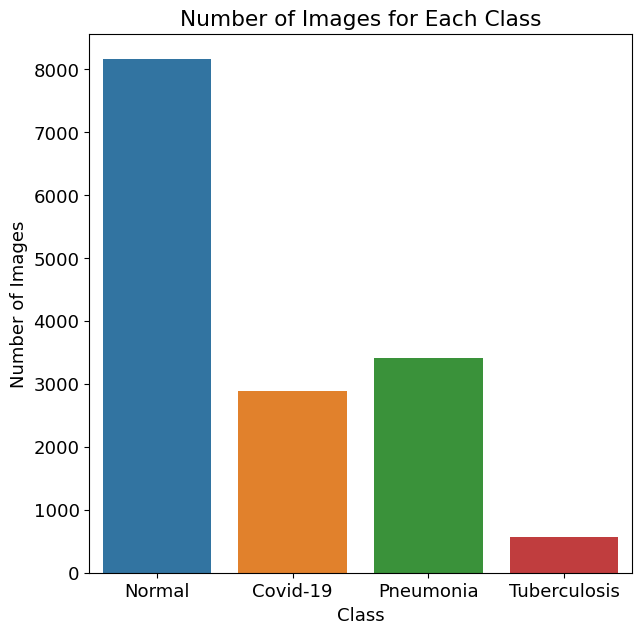

In [55]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(7,7))
sns.countplot(x = df_train['label'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images for Each Class')
plt.show()

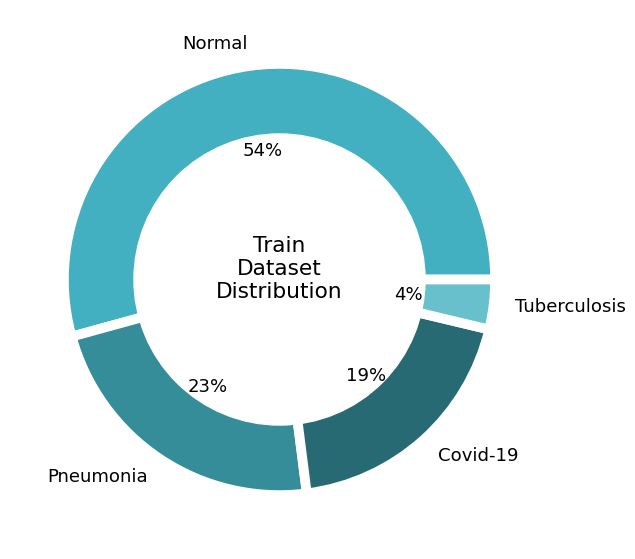

In [56]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(7,7))
# plotting data on chart
plt.pie(list(df_train.label.value_counts()),
        labels=list(df_train.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Train\nDataset\nDistribution', x=0.5, y=0.45) 
plt.show()

From the total dataset distribution, normal images accounts for more that half of the dataset with 54% while tuberculosis instances accounts for only 4% ot the total dataset. Other classes for pneumonia and Covid-19 accounts for 23% and 19% respectively. 

# 2. Pre-processing
Image Augmentation is a process that is used to create new images for training by slightly altering the pixel values.
We have a small dataset, so we can apply some image augmentation techniques to prevent overfitting of the model.
Techniques we will be using are:

1. Change the brightness of an image by a factor between 0.67 to 1.33
2. Change the contrast of an image by a factor between 0.67 to 1.33

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class configurations:
    IMAGE_SIZE = 224
    BRIGHTNESS = (0.64, 1.37) # (MIN, MAX)
    CONTRAST = (0.64, 1.37) # (MIX, MAX)
    BATCH_SIZE = 32
    EPOCHS = 5
    LEARNING_RATE = 0.001
def augment_image(image):
    datagen = ImageDataGenerator(
        brightness_range=configurations.BRIGHTNESS,
        #contrast_range=configurations.CONTRAST,
        #horizontal_flip=True,
        #vertical_flip=True,
        #rotation_range=20,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2
    )
    # Convert input image from numpy to PIL Image
    image = np.expand_dims(image, axis=0)
    # Apply Transformations
    image = datagen.flow(image, batch_size=1)[0][0]
    return image

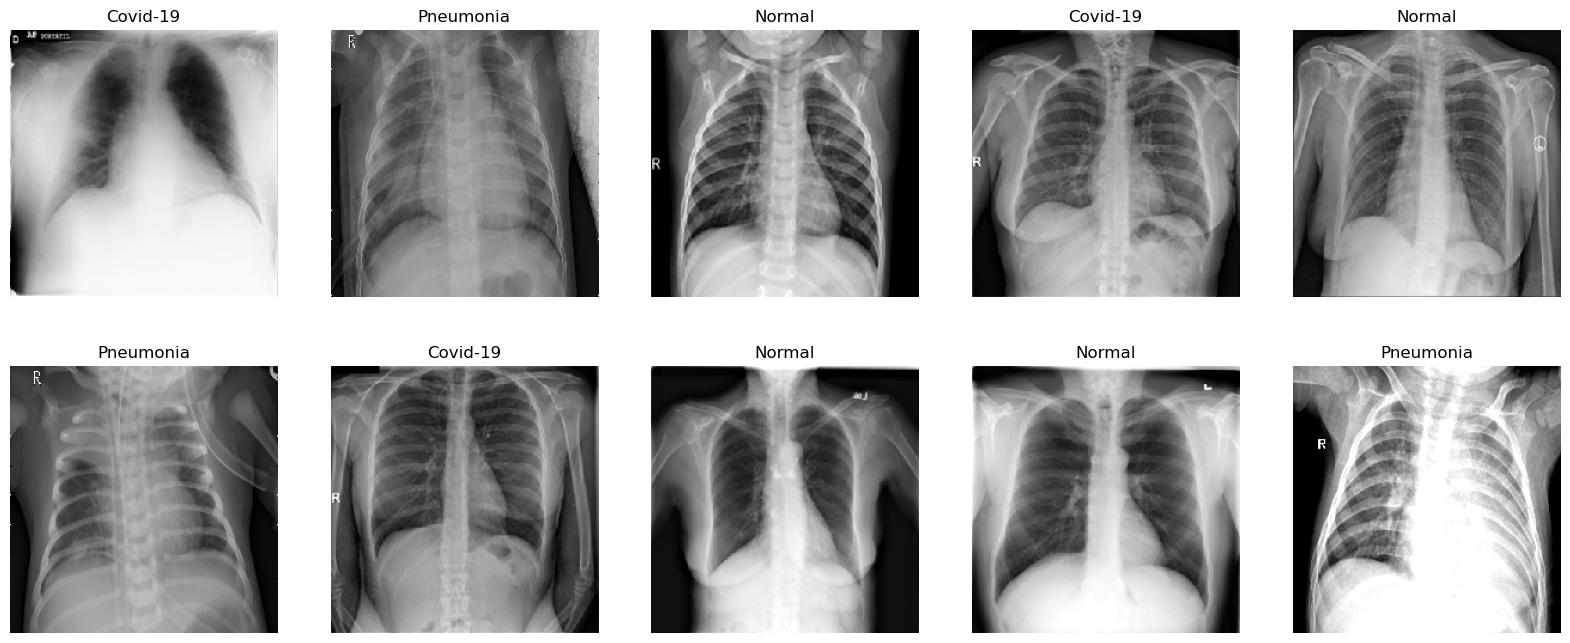

In [58]:
def open_images(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(configurations.IMAGE_SIZE,configurations.IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)
        image = image/image.max()
        images.append(image)
    return np.array(images)

# Randomly select and plot a few images with augmentation
k = random.randint(0,5000)
image_paths = list(df_train.path[k:k+10])
labels = list(df_train.label[k:k+10])
images = open_images(image_paths, augment=True)
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))

for i in range(0, 10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

In [59]:
##  Validation set
all_paths1 = []
all_labels1 = []
for label in os.listdir(val_dir):
    label_dir = os.path.join(val_dir, label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        all_paths1.append(image_path)
        all_labels1.append(label)
all_paths1, all_labels1 = shuffle(all_paths1, all_labels1)
pd.set_option('display.max_colwidth', None)
df_val = pd.DataFrame({'path':all_paths1, 'label':all_labels1})
df_val.head()

,path,label
0,/kaggle/working/dataset/val/Normal/Normal-7561.png,Normal
1,/kaggle/working/dataset/val/Normal/Normal-1064.png,Normal
2,/kaggle/working/dataset/val/Pneumonia/person59_bacteria_281.jpeg,Pneumonia
3,/kaggle/working/dataset/val/Pneumonia/person1558_bacteria_4066.jpeg,Pneumonia
4,/kaggle/working/dataset/val/Covid-19/COVID-3062.png,Covid-19


In [60]:
df_val.shape

(1877, 2)

In [61]:
df_val['label'].value_counts()

Normal          1019
Pneumonia        427
Covid-19         361
Tuberculosis      70
Name: label, dtype: int64

## 2.1 Label encoder-decoder
1. Creating a dictionary label_encoder to convert string label to interger-encoded label
2. And another dictionary label_decoder to decode the integer-encoded label

In [62]:
LABELS = ['Normal', 'Tuberculosis', 'Pneumonia', 'Covid-19']
label_encoder = {'Normal': 0, 'Tuberculosis': 1, 'Pneumonia': 2, 'Covid-19': 3}
label_decoder = {0: 'Normal', 1: 'Tuberculosis', 2: 'Pneumonia', 3: 'Covid-19'}

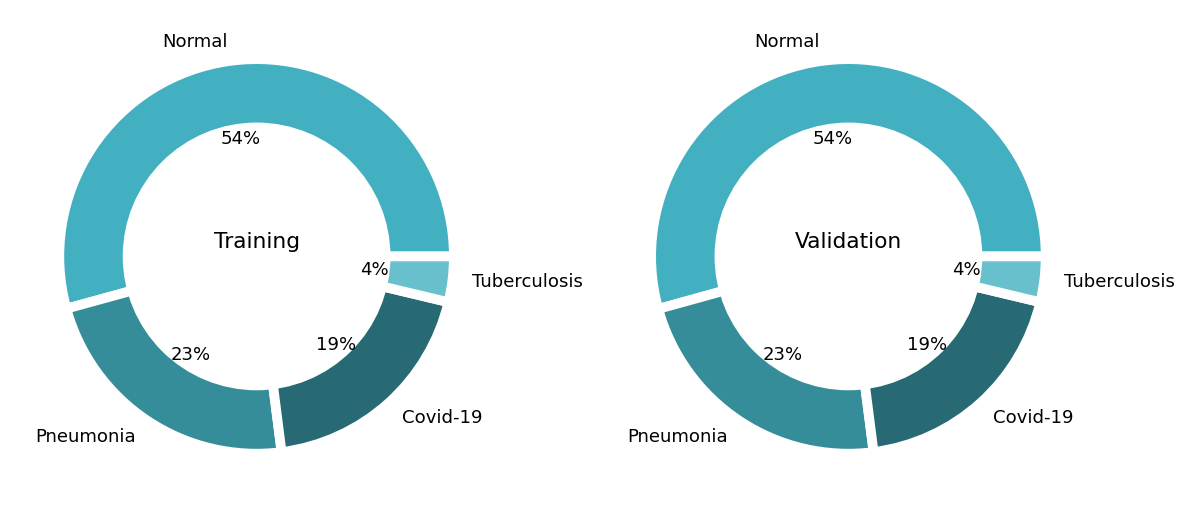

In [63]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(14, 7))

fig.add_subplot(1, 2, 1)
plt.pie(list(df_train.label.value_counts()),
        labels=list(df_train.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Training', x=0.5, y=0.5) 


fig.add_subplot(1, 2, 2)
plt.pie(list(df_val.label.value_counts()),
        labels=list(df_val.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Validation', x=0.5, y=0.5) 

plt.show()

Training a model on this highly imbalanced dataset will cause the model to overfit on the class that is in excess and fail to learn patterns from other classes. Fortunately, there are ways to tackle this problem. What we will be doing is assigning "class weights" to the classes, to handle the imbalanced classes. This will be computed in the later sections

## 2.3 Data Generators
data_generator is the generator function which we will use for training. It has 4 input parameters:

1. > df: This is the dataframe containing the image paths and labels \n
1. > batch_size (int): Batch size of training samples
1. > augment (boolean): If true, the augmentation techniques defined before will be applied to the images. We will set this to True during training and False during validation
1. > epochs (int): Number of epochs

In [64]:
def data_generator(df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [65]:
# Creating generators for training and validation. You can change the parameters in the configuration section.
train_data_generator = data_generator(df_train, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS)
train_steps = int(len(df_train)/configurations.BATCH_SIZE)

val_data_generator = data_generator(df_val, batch_size=configurations.BATCH_SIZE, augment=False, epochs=configurations.EPOCHS)
val_steps = int(len(df_val)/configurations.BATCH_SIZE)

# 3. Model

## 3.1 Model architecture 
* We are utilizing the inspiration of ResNet-50 model

In [66]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D,MaxPooling2D, Dropout, Flatten, Activation, Input, Add

In [67]:
resnet_model= ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
for layer in resnet_model.layers[:-10]:
    layers.trainable=False
hm = resnet_model.output
hm = AveragePooling2D(pool_size=(4,4))(hm)
hm = Flatten(name = 'flatten')(hm)
hm = Dense(256, activation = 'relu')(hm)
hm = Dropout(0.3)(hm)
hm = Dense(128, activation = 'relu')(hm)
hm = Dropout(0.2)(hm)
hm = Dense(4,activation = 'softmax')(hm)

model = Model(inputs=resnet_model.input, outputs = hm)

In [68]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## 3.2 Compile

This is the loss function we will be using:  

$$\mathcal{L}_{cross-entropy} = -\cfrac{1}{N}\sum_{i=1}^N [y_i\text{log}(\hat y_i) + (1-y_i)\text{log}(1-\hat y_i)]$$
where,  
$\quad\hat y$ is the predicted label, and $y$ is the actual label  
$\quad y_i$ is the $i^\mathbf{th}$ sample of $y$  and $\hat y_i$ is the $i^\mathbf{th}$ sample of $\hat y$  
$\quad N$ is the number of samples

`sparse_categorical_crossentropy` and `categorical_crossentropy` are basically the same loss functions, just their input formats are different.  
If $y_i$ is <b><mark>one-hot encoded</mark></b>, we use `categorical_crossentropy`, and if $y_i$ is <b><mark>integer-encoded</mark></b>, we use `sparse_categorical_crossentropy`  
For our case, the labels from the data generators are <b><mark>integer-encoded</mark></b>, so we are using `sparse_categorical_crossentropy`  

In [69]:
from tensorflow.keras.optimizers import SGD
sgd_optimizer = SGD(configurations.LEARNING_RATE)
model.compile(optimizer=sgd_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#model.compile(optimizer=optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
#            loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])

# 3.3 Training the model
As said earlier, we will be using 'class weights' to tackle the imbalanced dataset problem. Using the cross-entropy loss function will create a bias towards the dominating class. So, we will apply multipliers, or 'weights' to balance the loss function. This is called a <b><mark>weighted loss function</mark></b>:  
$$\mathcal{L}_{cross-entropy} = -\cfrac{1}{N}\sum_{i=1}^N [w_p y_i\text{log}(\hat y_i) + w_n (1-y_i)\text{log}(1-\hat y_i)]$$

So how do you calculate these so called weights $w_p$ and $w_n$ for each class? Just calculate the proportion of the dataset each class represents and tensorflow will handle the rest.  
`class_weights` is a dictionary of format `{'CLASS':'PROPORTION'}`

In [70]:
class_weights = (df_train.label.value_counts() / len(df_train)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights

{0: 0.5427011915063569,
 2: 0.22751780603075283,
 3: 0.19250482593356852,
 1: 0.037276176529321706}

In [71]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

history = model.fit(train_data_generator, epochs=configurations.EPOCHS, steps_per_epoch=train_steps, class_weight=class_weights,
          validation_data=val_data_generator, validation_steps=val_steps, callbacks=[model_checkpoint_callback])

Epoch 1/5
469/469 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.5886
Epoch 1: val_accuracy improved from -inf to 0.23545, saving model to /kaggle/working/model.hdf5
469/469 [==============================] - 130s 239ms/step - loss: 0.2747 - accuracy: 0.5886 - val_loss: 1.3369 - val_accuracy: 0.2355
Epoch 2/5
469/469 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.7391
Epoch 2: val_accuracy improved from 0.23545 to 0.69343, saving model to /kaggle/working/model.hdf5
469/469 [==============================] - 103s 220ms/step - loss: 0.1512 - accuracy: 0.7391 - val_loss: 0.8383 - val_accuracy: 0.6934
Epoch 3/5
469/469 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.7975
Epoch 3: val_accuracy improved from 0.69343 to 0.81681, saving model to /kaggle/working/model.hdf5
469/469 [==============================] - 106s 225ms/step - loss: 0.1106 - accuracy: 0.7975 - val_loss: 0.5237 - val_accuracy: 0.8168
Epoch 4/5
469/46

# 4. Evaluate the model

In [72]:
val_data_generator = data_generator(df_val, batch_size=configurations.BATCH_SIZE, augment=False, epochs=1)
val_steps = int(len(df_val)/configurations.BATCH_SIZE)

y_pred = []
y_true = []

for x,y in tqdm(val_data_generator, total=val_steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(label_decoder[i])
    for i in y:
        y_true.append(label_decoder[i])
clear_output()
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

    Covid-19     0.8192    0.4017    0.5390       361
      Normal     0.8002    0.9941    0.8867      1019
   Pneumonia     0.9677    0.9836    0.9756       427
Tuberculosis     0.0000    0.0000    0.0000        70

    accuracy                         0.8407      1877
   macro avg     0.6468    0.5948    0.6003      1877
weighted avg     0.8121    0.8407    0.8070      1877



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# 5. Conclusion and Deployment

In [73]:
def predict(image, model):
    '''
    Input the image and model, this function outputs the prediction as:
        1. The class with the highest probability
        2. A dictionary containing each class with their corresponding probability
    '''
    labels = ['Normal', 'Tuberculosis', 'Pneumonia', 'Covid-19']
    image = np.array(image)
    image = image/image.max()
    image = image.reshape(-1,configurations.IMAGE_SIZE,configurations.IMAGE_SIZE,3)
    probabilities = model.predict(image).reshape(-1)
    pred = labels[np.argmax(probabilities)]
    return pred, {x:y for x,y in zip(labels, probabilities)}

INDICES = random.sample(list(df.index), 7)

for INDEX in INDICES:

    image = load_img(df.path[INDEX], target_size=(configurations.IMAGE_SIZE, configurations.IMAGE_SIZE))
    pred, probabilities = predict(image, model)

    x = list(probabilities.keys())
    y = list(probabilities.values())

    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1,2, figsize=(16,4), gridspec_kw={'width_ratios': [3, 4]})
    ax[0].imshow(image)
    ax[0].axis('off')

    bars = ax[1].barh(x, y, height=0.3, color=['#69c0cd', '#69c0cd', '#69c0cd', '#69c0cd'])
    ax[1].bar_label(bars)
    
    ax[1].set_title('Predicted Class Probabilities')
    plt.xlim([0, 1])
    plt.show()

    print('Actual   :',df.label[INDEX])
    print('Predicted:', pred)
    print('-'*80)
    print('\n')

NameError: name 'df' is not defined

**Accuracy plot**

In [ ]:
epochs = range (1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], color = 'purple')
plt.plot(epochs, history.history['val_accuracy'], color = 'pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.legend(["train_acc","val_acc"])
plt.show()

**Loss plots**

In [ ]:
plt.plot(epochs, history.history['loss'], color = 'purple')
plt.plot(epochs, history.history['val_loss'], color = 'pink')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.legend(["train_loss","val_loss"])
plt.show()

## 2. Experimenting with other deep transfer learning techniques